# Modelling and Performance (Part 1)

The data challenge require to define a strategy to **re-rank NPL customers according to the likelihood to repay** and/or by **suggesting new strategies to maximize the recovery rate**.

These requirements can be split into two separate tasks:
1. Estimate the likelihood to repay, i.e. the probability that a paiement (any amount) is performed
2. Estimate the recovery rate, i.e. the amount recovered w.r.t. the total debt.

Both tasks can be adressed using the targed variables defined in the *data_cleaning.ipynb* notebook which represent the realized recovery rate 12 month ahead and its boolean value. 

Both tasks require the definition of a time horizon since the portfolio manager will be interested to know [1] and [2] within a certain time. The definition of time horizon is arbitrary, i.e. should be the portfolio manager to suggest which window he/she is interested to look at. For the sake of this challenge, I consider a 12 months window.

Task [1] will be performed by a classification model trained against a boolean target variable defined as True in the case of any income in the next 12 months, False otherwise. The trained classifier will output the probability of Target==True (or Target==False), which can be interpreted as the likelihood of repayment.

Task [2] will be performed by a regression model trained on the realized recovery rate 12 month ahead. The trained regressor will provide estimates of the expected recovery rate in the next 12 months.

Since I plan to use a supervised machine learning approach, only NPL with a 12 months lookahead will be used in the model training/testing. NPLs with a time horizon smaller than 12 months does not allow to define the target values since the information 12 month ahead is not available. NPLs without 12 month horizon will be used as prediction sample, i.e. NPLs for which the portfolio manager will be interested to know how to treat.

Using the model developed in this notebook, it will be possible to rank NPLs as using:
1. The probability of repaiment in the next 12 months (output of the classifier)
2. The amount of the recovered amount in the next 12 months (output of the regressor)

The ranking will be performed in the *predict_and_rank.ipynb* notebook using the prediction dataset.

The following steps will be performed:

1. **Check correlations**: Identify which features are more informative and provide predictive power w.r.t. the target variables;
2. **Feature selections**: Select the most informative features from the outcome of the previous step;
3. **Sample preparation**: Prepare the sample dividing training, testing and prediction samples
4. **Principal Component Analysis**: Performa a PCA to identify which are the principal components explaing the variance observed in the data
5. **Test different Classification models**: Test different models and compare performances with cross-validation
6. **Test different Regression models**: Test different models and compare performances with cross-validation

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os.path as path
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

## Load pre-processed dataset

In [2]:
df = pd.read_csv('sample_for_model.csv'
                  , parse_dates=['NUM_ANNO', 'NUM_YYYYMM', 'NUM_DATA_SOFFERENZA']
                  , dtype={'HAS_RECOVERED_12M': bool, 'HAS_RECOVERED_12M_AHEAD': bool})

In [3]:
df.shape

(484743, 46)

In [4]:
#df.info()

In [5]:
#df.isnull().sum(axis = 0)

In [6]:
df.head()

,NUM_ANNO,NUM_YYYYMM,FILIALE,ID_CUSTOMER,NUM_DATA_SOFFERENZA,IMP_GBV,IMP_INCASSI,IMP_CUSUM_INCASSI,MAX_IMP_GBV,RECOVERY_RATE_TOTAL,...,NUM_ID_RAPPORTO,NUM_ID_GARANTE,COD_STATO_KTO,IMP_GAR,IMP_INCASSI_ROLLING_12M,HAS_RECOVERED_12M,RECOVERY_RATE_12M,IMP_INCASSI_ROLLING_12M_AHEAD,HAS_RECOVERED_12M_AHEAD,RECOVERY_RATE_12M_AHEAD
0,2015-01-01,2015-01-01,13484,1,2009-01-01,3222.83,0.0,0.0,3561.0,0.0,...,2.0,2.0,True,19786.92,0.0,False,0.0,0.0,False,0.0
1,2015-01-01,2015-02-01,13484,1,2009-01-01,3387.87,0.0,0.0,3561.0,0.0,...,2.0,2.0,True,19786.92,0.0,False,0.0,0.0,False,0.0
2,2015-01-01,2015-03-01,13484,1,2009-01-01,3387.87,0.0,0.0,3561.0,0.0,...,2.0,2.0,True,19786.92,0.0,False,0.0,0.0,False,0.0
3,2015-01-01,2015-04-01,13484,1,2009-01-01,3387.87,0.0,0.0,3561.0,0.0,...,2.0,2.0,True,19786.92,0.0,False,0.0,0.0,False,0.0
4,2015-01-01,2015-05-01,13484,1,2009-01-01,3387.87,0.0,0.0,3561.0,0.0,...,2.0,2.0,True,19786.92,0.0,False,0.0,0.0,False,0.0


## Check correlations 
I use the Pearson's correlation coefficients to identify which features have predictive power w.r.t. 'RECOVERY_RATE_12M_AHEAD' and 'IMP_INCASSI_ROLLING_12M_AHEAD'

In [7]:
df.columns

Index(['NUM_ANNO', 'NUM_YYYYMM', 'FILIALE', 'ID_CUSTOMER',
       'NUM_DATA_SOFFERENZA', 'IMP_GBV', 'IMP_INCASSI', 'IMP_CUSUM_INCASSI',
       'MAX_IMP_GBV', 'RECOVERY_RATE_TOTAL', 'NUM_MONTHS_SOFFERENZA',
       'Contabile linea capitale', 'Contabile linea interessi di mora',
       'Credito vantato', 'IMP_ACCRDT', 'IMP_UTLZT', 'IMP_VAL_GAR',
       'IMP_GARNTT', 'IMP_SCONFNM', 'IMP_MARGN_UTLZ', 'NUM_ENTI_SEGNALANTI',
       'IMP_CAPTL_RESID', 'IMP_TOT_SCADUTO', 'IMP_TOT_MORA', 'IMP_GBV_MUTUI',
       'NUM_RATE_PAGT', 'NUM_RATE_IMPGT', 'IMP_ULTM_RATA_SCADT',
       'COD_SPECIE_GIURIDICA', 'NUM_COMPONENTI_COINTESTAZIONE', 'COD_TIPO_NDG',
       'COD_PROVINCIA_RESIDENZA', 'DES_PROFESSIONE_ATTIVITA', 'DES_RAE',
       'DES_SAE', 'DES_PROVINCIA_NASCITA', 'NUM_ID_RAPPORTO', 'NUM_ID_GARANTE',
       'COD_STATO_KTO', 'IMP_GAR', 'IMP_INCASSI_ROLLING_12M',
       'HAS_RECOVERED_12M', 'RECOVERY_RATE_12M',
       'IMP_INCASSI_ROLLING_12M_AHEAD', 'HAS_RECOVERED_12M_AHEAD',
       'RECOVERY_RATE_1

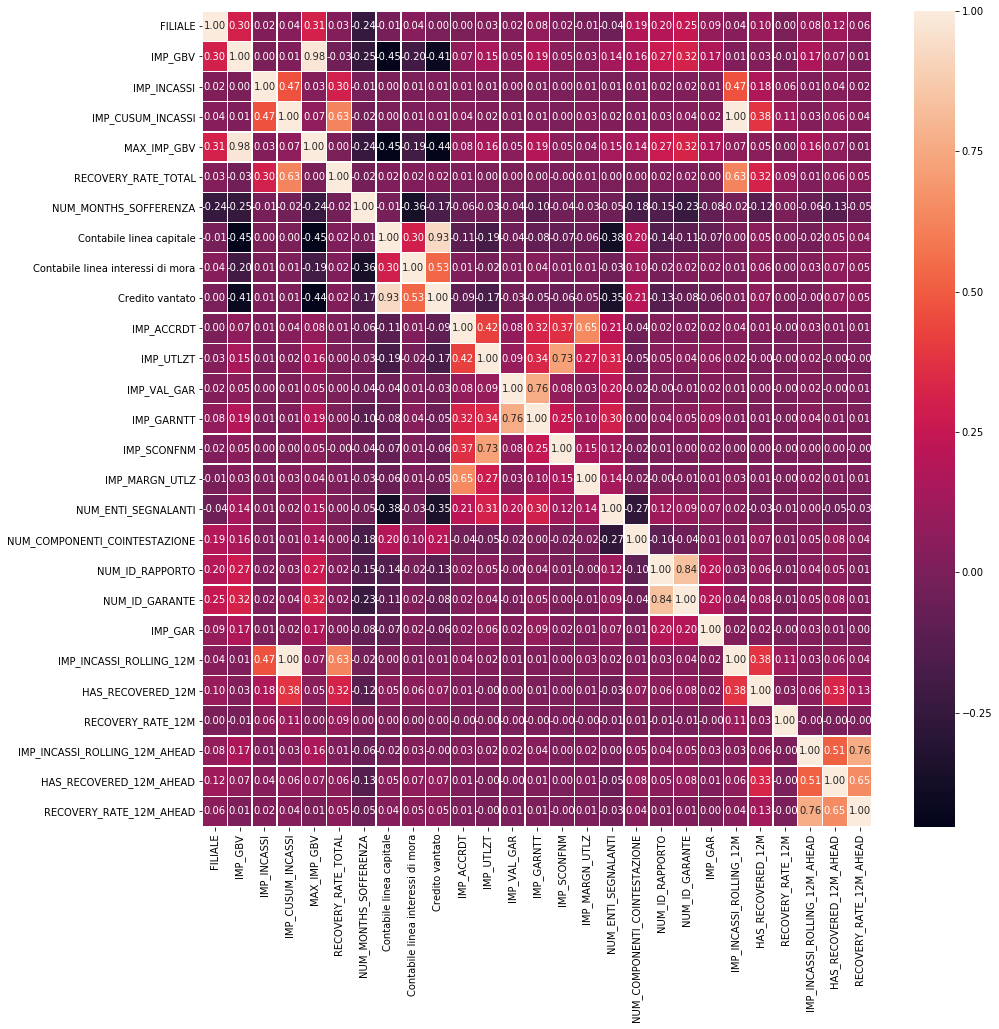

In [8]:
cols=['FILIALE', 
      'NUM_DATA_SOFFERENZA', 
      'IMP_GBV', 
      'IMP_INCASSI', 
      'IMP_CUSUM_INCASSI',
      'MAX_IMP_GBV', 
      'RECOVERY_RATE_TOTAL', 
      'NUM_MONTHS_SOFFERENZA',
      'Contabile linea capitale', 
      'Contabile linea interessi di mora',
      'Credito vantato', 
      'IMP_ACCRDT', 
      'IMP_UTLZT', 
      'IMP_VAL_GAR',
      'IMP_GARNTT', 
      'IMP_SCONFNM', 
      'IMP_MARGN_UTLZ', 
      'NUM_ENTI_SEGNALANTI',
      'NUM_COMPONENTI_COINTESTAZIONE', 
      'NUM_ID_RAPPORTO', 
      'NUM_ID_GARANTE',
      'IMP_GAR', 
      'IMP_INCASSI_ROLLING_12M',
      'HAS_RECOVERED_12M', 
      'RECOVERY_RATE_12M',
      'IMP_INCASSI_ROLLING_12M_AHEAD', 
      'HAS_RECOVERED_12M_AHEAD',
      'RECOVERY_RATE_12M_AHEAD'
     ]
tmp=df.loc[~df['HAS_RECOVERED_12M_AHEAD'].isna()].copy()
tmp['HAS_RECOVERED_12M_AHEAD']=tmp['HAS_RECOVERED_12M_AHEAD'].astype(bool)
corr=tmp[cols].corr()
f, ax = plt.subplots(figsize=(15,15))
sns.heatmap(corr, annot=True, linewidths=.5, fmt=".2f", ax=ax)
plt.show()

* Here I show explicitely the correlations with the target variables;
* I also highlight which features show a correlation above 5%;
* Correlation below 5% are really less informative;
* The treshold of 5% is arbitrary and is chosed by looking at the dataset.

In [9]:
c = corr[['HAS_RECOVERED_12M_AHEAD','RECOVERY_RATE_12M_AHEAD']]
s = corr[['HAS_RECOVERED_12M_AHEAD','RECOVERY_RATE_12M_AHEAD']].abs()>0.05
a = (corr[['HAS_RECOVERED_12M_AHEAD','RECOVERY_RATE_12M_AHEAD']].abs()>0.05).any(axis=1)
pd.concat([c, s, a], axis=1)

,HAS_RECOVERED_12M_AHEAD,RECOVERY_RATE_12M_AHEAD,HAS_RECOVERED_12M_AHEAD,RECOVERY_RATE_12M_AHEAD,0
FILIALE,0.118062,0.061772,True,True,True
IMP_GBV,0.074235,0.010196,True,False,True
IMP_INCASSI,0.036884,0.023614,False,False,False
IMP_CUSUM_INCASSI,0.064372,0.039674,True,False,True
MAX_IMP_GBV,0.065924,0.005434,True,False,True
RECOVERY_RATE_TOTAL,0.060487,0.054741,True,True,True
NUM_MONTHS_SOFFERENZA,-0.125404,-0.054890,True,True,True
Contabile linea capitale,0.045636,0.039562,False,False,False
Contabile linea interessi di mora,0.073338,0.051384,True,True,True
Credito vantato,0.070276,0.054782,True,True,True


### Features that show a good correlation with the target variables
This is the short-list of features that show a correlation coefficient bigger than 5% against either of the two target variables.

In [10]:
feat_sel = list(a.index[a][:-3])
feat_sel

['FILIALE',
 'IMP_GBV',
 'IMP_CUSUM_INCASSI',
 'MAX_IMP_GBV',
 'RECOVERY_RATE_TOTAL',
 'NUM_MONTHS_SOFFERENZA',
 'Contabile linea interessi di mora',
 'Credito vantato',
 'NUM_ENTI_SEGNALANTI',
 'NUM_COMPONENTI_COINTESTAZIONE',
 'NUM_ID_RAPPORTO',
 'NUM_ID_GARANTE',
 'IMP_INCASSI_ROLLING_12M',
 'HAS_RECOVERED_12M']

### Some considerations on categorical features

In [11]:
#corr2=df[feat_sel].corr()
#f, ax = plt.subplots(figsize=(15,15))
#sns.heatmap(corr2, annot=True, linewidths=.5, fmt=".2f", ax=ax)
#plt.show()

In [12]:
# Exclude because it's meaning is not clear at this 
# stage and could introduce some bias
df['FILIALE'].value_counts(normalize=True)

13484    0.504057
13720    0.292631
13721    0.203312
Name: FILIALE, dtype: float64

In [13]:
# Keep it because it might helps differenciate among customer type
df['COD_TIPO_NDG'].value_counts(normalize=True)

G    0.438604
F    0.336017
C    0.225379
Name: COD_TIPO_NDG, dtype: float64

In [14]:
# Exclude because variance is too low
df['HAS_RECOVERED_12M'].value_counts(normalize=True)

False    0.89618
True     0.10382
Name: HAS_RECOVERED_12M, dtype: float64

In [15]:
# Exclude because Introduce too many values, most of which are under-represented
# Correlated with 'COD_TIPO_NDG'
df['COD_SPECIE_GIURIDICA'].value_counts(normalize=True)

# Same for these:
#,'COD_PROVINCIA_RESIDENZA'
#,'DES_PROFESSIONE_ATTIVITA'
#,'DES_PROVINCIA_NASCITA'
#,'DES_RAE'
#,'DES_SAE'

PF       0.335452
CO       0.225379
SRL      0.154500
DI       0.153584
SNC      0.055861
SAS      0.050550
SCRL     0.010141
SPA      0.006841
SS       0.003301
ENTE     0.001277
SE       0.000549
CONS     0.000497
PFE      0.000437
FALNC    0.000398
SDF      0.000237
COOSC    0.000186
PSCRL    0.000157
ASNR     0.000134
SCRLA    0.000122
COND     0.000118
PFINB    0.000093
STU      0.000070
FILIT    0.000045
PFI      0.000035
FALLC    0.000023
LTDC     0.000012
Name: COD_SPECIE_GIURIDICA, dtype: float64

## Features selection
I decided to focus on the features that show a correlation bigger than 5% with either of the two target variable. This choice might seem arbitrary but it is actually based on a measurable and reproducible approach, because only the features that bring measurable information and prediction power w.r.t. the target variables are considered.

Another approach could have been to take in all the features and leave the model the task to rank them and highlight the most informative. I personally do not like this black-box approach, at least when there is a way to deal with the feature selection in a measurable way.

Once the baseline performance of the models is set, an optimization process that add/remove features iteratively, could be considered during the cross-validation to check how performances change.

As regard the categorical features, I decided to employ only 'COD_TIPO_NDG'and use one-hot encoding to enumerate it. The reason behind this choice is due to the large amount of categories present in the dataset. Categorical features are dangerous when the sample is not well balanced among categories. If performance are accettable with the current choice of features, I would defer the use of additional categoricals for future verison.

In [16]:
numerical_cols=[
    'IMP_GBV',
    'IMP_CUSUM_INCASSI',
    'MAX_IMP_GBV',
    'RECOVERY_RATE_TOTAL',
    'NUM_MONTHS_SOFFERENZA',
    'Contabile linea interessi di mora',
    'Credito vantato',
    'NUM_ENTI_SEGNALANTI',
    'NUM_COMPONENTI_COINTESTAZIONE',
    'NUM_ID_RAPPORTO',
    'NUM_ID_GARANTE',
    'IMP_INCASSI_ROLLING_12M',
]
categorical_cols=['COD_TIPO_NDG']

target_classifier = 'HAS_RECOVERED_12M_AHEAD'
target_regressor = 'RECOVERY_RATE_12M_AHEAD'

## Encode categorical features

In [17]:
prefix = ['CAT_' + s for s in categorical_cols]

df_encoded=pd.get_dummies(df, columns=categorical_cols, dummy_na=True, prefix=prefix)

encoded_categorical_cols = list(filter(lambda x: 'CAT_' in x, df_encoded.columns))

In [18]:
df_encoded.shape

(484743, 49)

## Divide sample: Training/Test & Prediction

* Data row with a 12 months ahead horizon is defined are considered for the model training;
* Data row without a 12 months ahead horizon will be used as prediction sample;
* The sample is divided between train and test with the typical ratio of 80:20.

In [19]:
# Train/Test sample: entry with a 12 month ahead horizon
sample_train_test=df_encoded.loc[~df_encoded['HAS_RECOVERED_12M_AHEAD'].isna()]
sample_train_test.shape

(218367, 49)

In [20]:
# Prediction sample:
#sample_prediction=df_encoded.loc[df_encoded['NUM_YYYYMM'] == df_encoded['NUM_YYYYMM'].max()]
#sample_prediction.shape

In [21]:
X = sample_train_test[numerical_cols+encoded_categorical_cols].copy()
y = sample_train_test[[target_classifier, target_regressor]]

The balance of the sample among the false class (no recovery) and the positive class (recovery) is:

In [22]:
y[target_classifier].value_counts(normalize=True)

False    0.863413
True     0.136587
Name: HAS_RECOVERED_12M_AHEAD, dtype: float64

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

y_train_classifier = y_train[target_classifier].astype(bool)
y_test_classifier = y_test[target_classifier].astype(bool)

y_train_regressor = y_train[target_regressor].astype(float)
y_test_regressor = y_test[target_regressor].astype(float)

In [24]:
# TEST
#X.isnull().sum(axis = 0)

In [25]:
# TEST
#y_classifier.isnull().sum(axis = 0)

## PCA
The Principal Component Analysis is used to decompose a multivariate dataset in a set of successive orthogonal components that explain a maximum amount of the variance. It is by far the most popular dimensionality reduction algorithm.

In this context I use the PCA to understand which is the minimal number of Principal Component necessary to explain 100% of the variance observed in the data. In this way I can employ PCA with the right amount of component and test model performance with and without dimensionality reduction. 

In [26]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X)

for i,v in enumerate(pca.explained_variance_ratio_.cumsum()):
    print('Component %d, explained variance %.3f' % (i, v))
    
    idx=np.argsort(pca.components_[i])
    for j in idx[::-1][:5]:
        print('  %.3f, %s' %(pca.components_[i][j], X.columns[j]))

Component 0, explained variance 0.793
  0.689, MAX_IMP_GBV
  0.656, IMP_GBV
  0.002, IMP_CUSUM_INCASSI
  0.002, IMP_INCASSI_ROLLING_12M
  0.000, NUM_ID_RAPPORTO
Component 1, explained variance 0.973
  0.007, NUM_MONTHS_SOFFERENZA
  0.000, NUM_ENTI_SEGNALANTI
  0.000, CAT_COD_TIPO_NDG_G
  -0.000, CAT_COD_TIPO_NDG_nan
  -0.000, RECOVERY_RATE_TOTAL
Component 2, explained variance 0.987
  0.955, Contabile linea interessi di mora
  0.161, MAX_IMP_GBV
  0.046, IMP_INCASSI_ROLLING_12M
  0.046, IMP_CUSUM_INCASSI
  0.000, NUM_ENTI_SEGNALANTI
Component 3, explained variance 0.996
  0.536, MAX_IMP_GBV
  0.420, IMP_INCASSI_ROLLING_12M
  0.420, IMP_CUSUM_INCASSI
  0.062, Credito vantato
  0.007, NUM_MONTHS_SOFFERENZA
Component 4, explained variance 1.000
  0.567, IMP_INCASSI_ROLLING_12M
  0.567, IMP_CUSUM_INCASSI
  0.419, IMP_GBV
  0.087, Contabile linea interessi di mora
  0.000, NUM_ENTI_SEGNALANTI
Component 5, explained variance 1.000
  1.000, NUM_MONTHS_SOFFERENZA
  0.023, Contabile linea inter

## Import custom utils library
I make a large use of some utils function I developed for similar tasks in the past.

In [27]:
from classifier_utils import *

## Classifier

For the classification task, I use the selected features to train a classification model to predict the target variable 'HAS_RECOVERED_12M_AHEAD'.

I test three models:
1. **Logistic regression**
2. **Extra random trees**
3. **Random forest**

All models are tested with and without PCA for dimensionality reduction using 4 components, as highlighed in the analysis performed right above.

### Model performance:

For each model, the performance are evaluated using different metrics: 
* **Precision**: measure the proportion of correctly predicted instances (P = tp / (tp + fp))
* **Recall**: measures the proportion of actual prediction that are correctly identified (R = tp / (tp + fn))
* **F1**: harmonic mean of Precision and Recall
* **ROC AUC**: measure the probability the classifier perform better than a random choice

The metrics are calculated on the test sample as well as on the train sample using a 3-fold cross-validation approach to test for model overfitting. The model with the highest performance will be retained.

### Model quality:

Aside from the numerical metrics, some additional handle on the model performance is given by the plot provided for each model tested:

* **Model reliability curve**: check if the classifier output can be interpreted as an estimate of the probability to belong to the given class;
* **Receiver operating characteristic**: shows the performance of the classifier as its discrimination threshold is varied. Its also shows distance from the performance provided by random choice (blue dashed line);
* **Confusion matrix**: overview of the classification accuracy by counting the number of True/False Positive/Negative instances;
* **Classification probability**: distribution of the probability for the True and the Negative class;
* **Precision-Recall curve**: shows the performance of the classifier, in term of Precision and Recall as its discrimination threshold is varied;
* **Feature importance**: the importance given by the model to the features used during the model training (features are enumerated by their position in the feature vector).

In [28]:
y_train = y_train_classifier
y_test = y_test_classifier

In [29]:
print('Train shape: ', X_train.shape)
print('Test shape: ', X_test.shape)

Train shape:  (174693, 16)
Test shape:  (43674, 16)


### Logistic Regression w/o PCA

In [30]:
%%time

from sklearn.linear_model import LogisticRegression

model=train_model('Logit'
            , model = LogisticRegression( solver='liblinear', class_weight='balanced', max_iter=500)
            , X=X_train, y=y_train
            , categorical_features=[]
            , pca_n_components=0
            , save=False)

CPU times: user 783 ms, sys: 34.2 ms, total: 817 ms
Wall time: 818 ms


In [31]:
# Performance on 1 split
from sklearn.metrics import classification_report
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.92      0.66      0.77     37663
        True       0.23      0.66      0.35      6011

    accuracy                           0.66     43674
   macro avg       0.58      0.66      0.56     43674
weighted avg       0.83      0.66      0.71     43674



In [32]:
# Cross validation
cross_validate_model(model, X_train, y_train, cv=3)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.9s finished


,F1,Precision,Recall,Roc auc
error,0.003196,0.002244,0.005495,0.003801
value,0.336407,0.227462,0.645643,0.691774


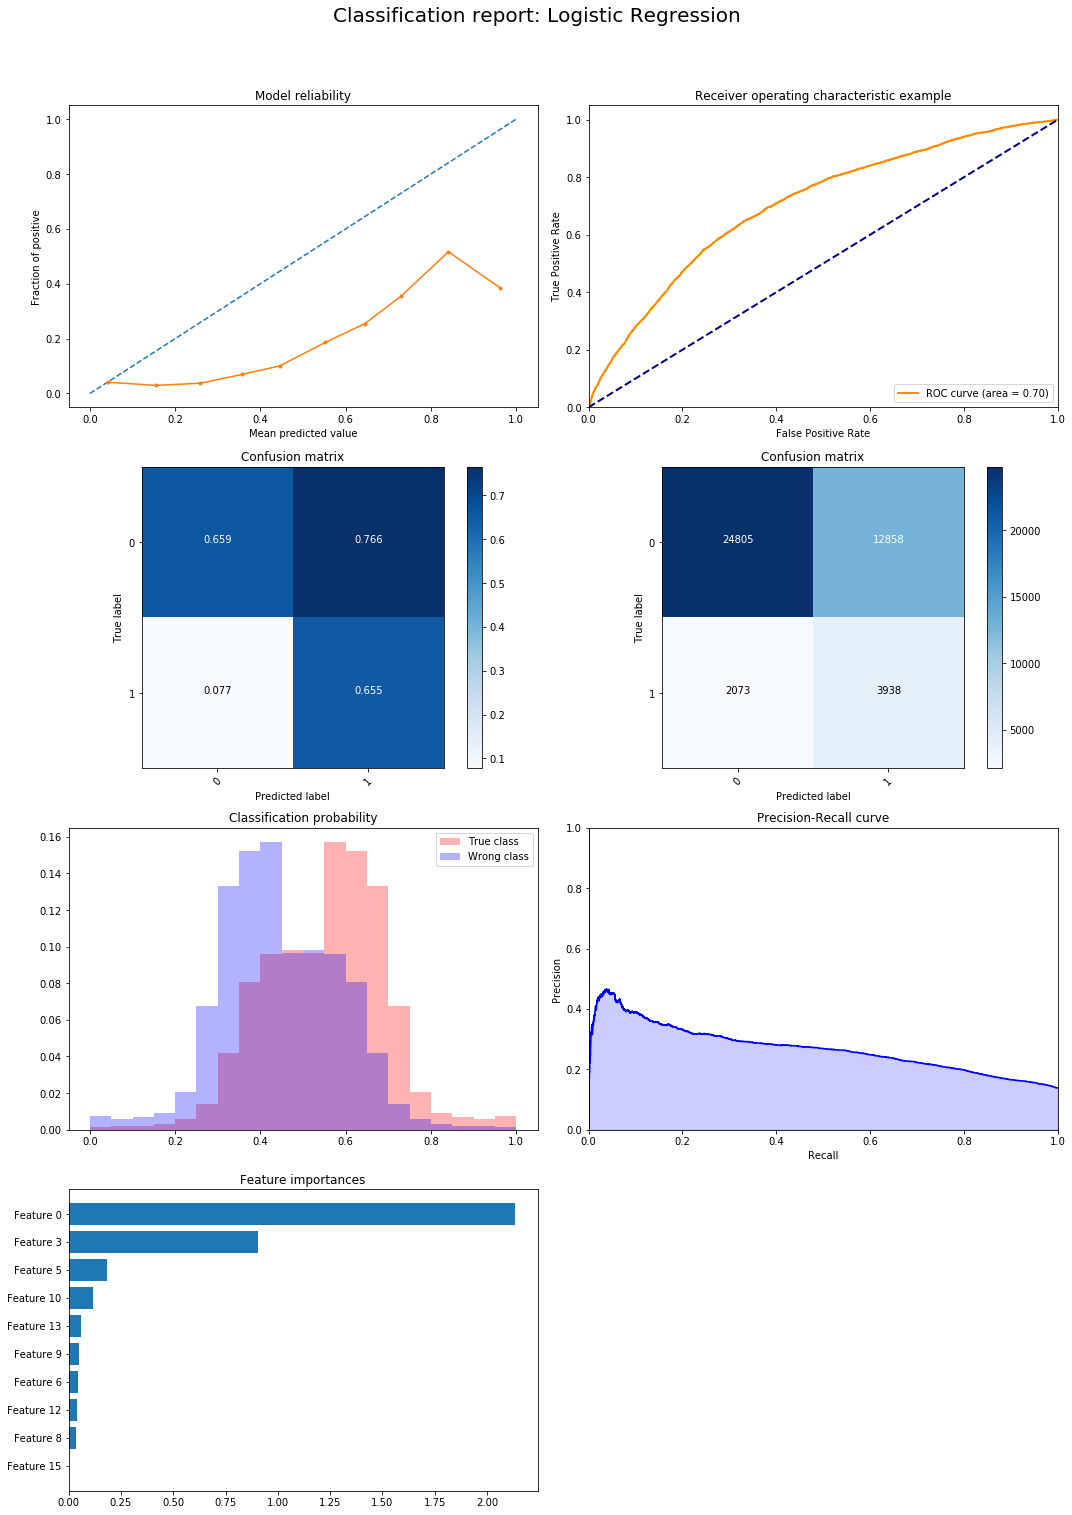

In [33]:
plot_report('Logistic Regression', model, X_test, y_test)

* Performance are rather poor: F1 = 0.34;
* The clasisfication probability plot shows poor class separation;
* The model gives more weights to IMP_GBV (Feature 0) and RECOVERY_RATE_TOTAL (Feature 3);

## Logistic Regression w/ PCA

In [34]:
%%time

from sklearn.linear_model import LogisticRegressionCV

model=train_model('Logit'
            , model = LogisticRegression(solver='liblinear', class_weight='balanced', max_iter=500)
            , X=X_train, y=y_train
            , categorical_features=[]
            , pca_n_components=4
            , save=False)

CPU times: user 571 ms, sys: 154 ms, total: 725 ms
Wall time: 569 ms


In [35]:
# Performance on 1 split
from sklearn.metrics import classification_report
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.91      0.65      0.76     37663
        True       0.21      0.59      0.31      6011

    accuracy                           0.64     43674
   macro avg       0.56      0.62      0.54     43674
weighted avg       0.81      0.64      0.70     43674



In [36]:
# Cross validation
cross_validate_model(model, X_train, y_train, cv=3)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.1s finished


,F1,Precision,Recall,Roc auc
error,0.003128,0.002970,0.006664,0.004784
value,0.302847,0.205373,0.576611,0.653859


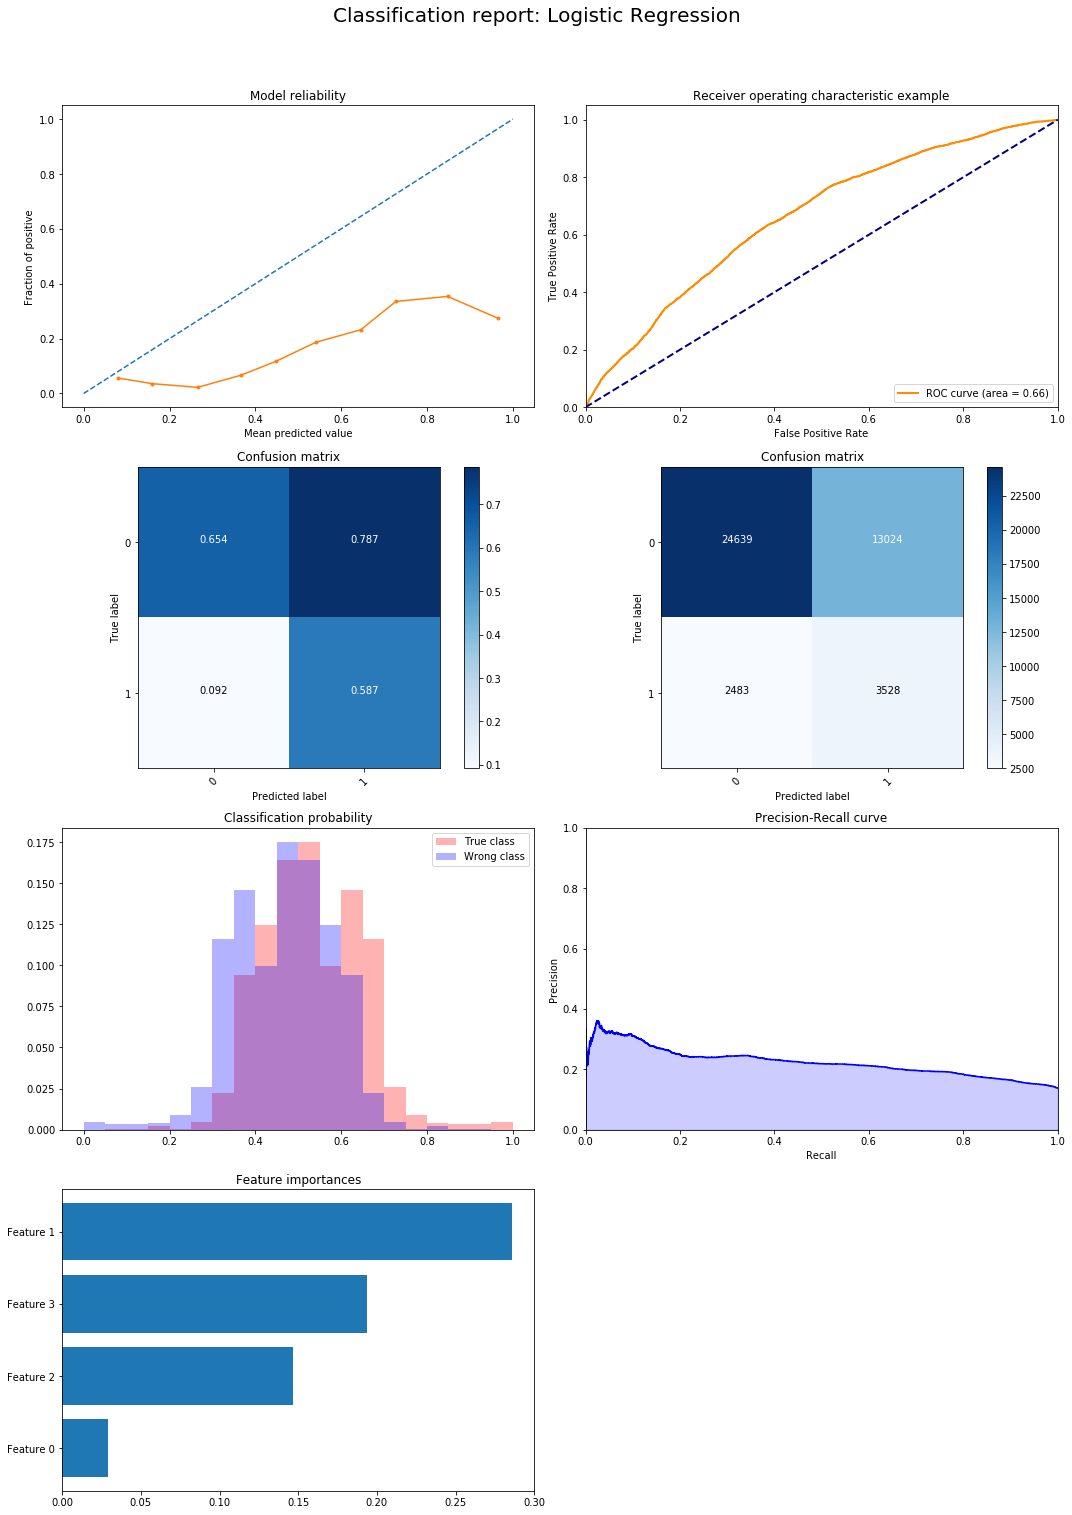

In [37]:
plot_report('Logistic Regression', model, X_test, y_test)

* Performance worsten using the PCA: F1 = 0.32;
* The clasisfication probability plot shows poor class separation;
* The model gives more weights to PCA Feature 1 and 3 (to see actual composition please refer to the PCA analysis above);

## Extra Random Tree w/o PCA

In [38]:
%%time

from sklearn.ensemble import ExtraTreesClassifier

model=train_model('ETC'
            , model = ExtraTreesClassifier(n_estimators=250, min_samples_split=10, min_samples_leaf=10, n_jobs=-1, random_state=0, class_weight='balanced_subsample')
            , X=X_train, y=y_train
            , categorical_features=[]
            , pca_n_components=0
            , save=False)

CPU times: user 46.5 s, sys: 596 ms, total: 47.1 s
Wall time: 14.2 s


In [39]:
# Performance on 1 split
from sklearn.metrics import classification_report
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.96      0.81      0.88     37663
        True       0.41      0.81      0.54      6011

    accuracy                           0.81     43674
   macro avg       0.69      0.81      0.71     43674
weighted avg       0.89      0.81      0.84     43674



In [40]:
# Cross validation
cross_validate_model(model, X_train, y_train, cv=3)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   35.8s finished


,F1,Precision,Recall,Roc auc
error,0.004954,0.005110,0.000580,0.002717
value,0.463926,0.336874,0.744951,0.856320


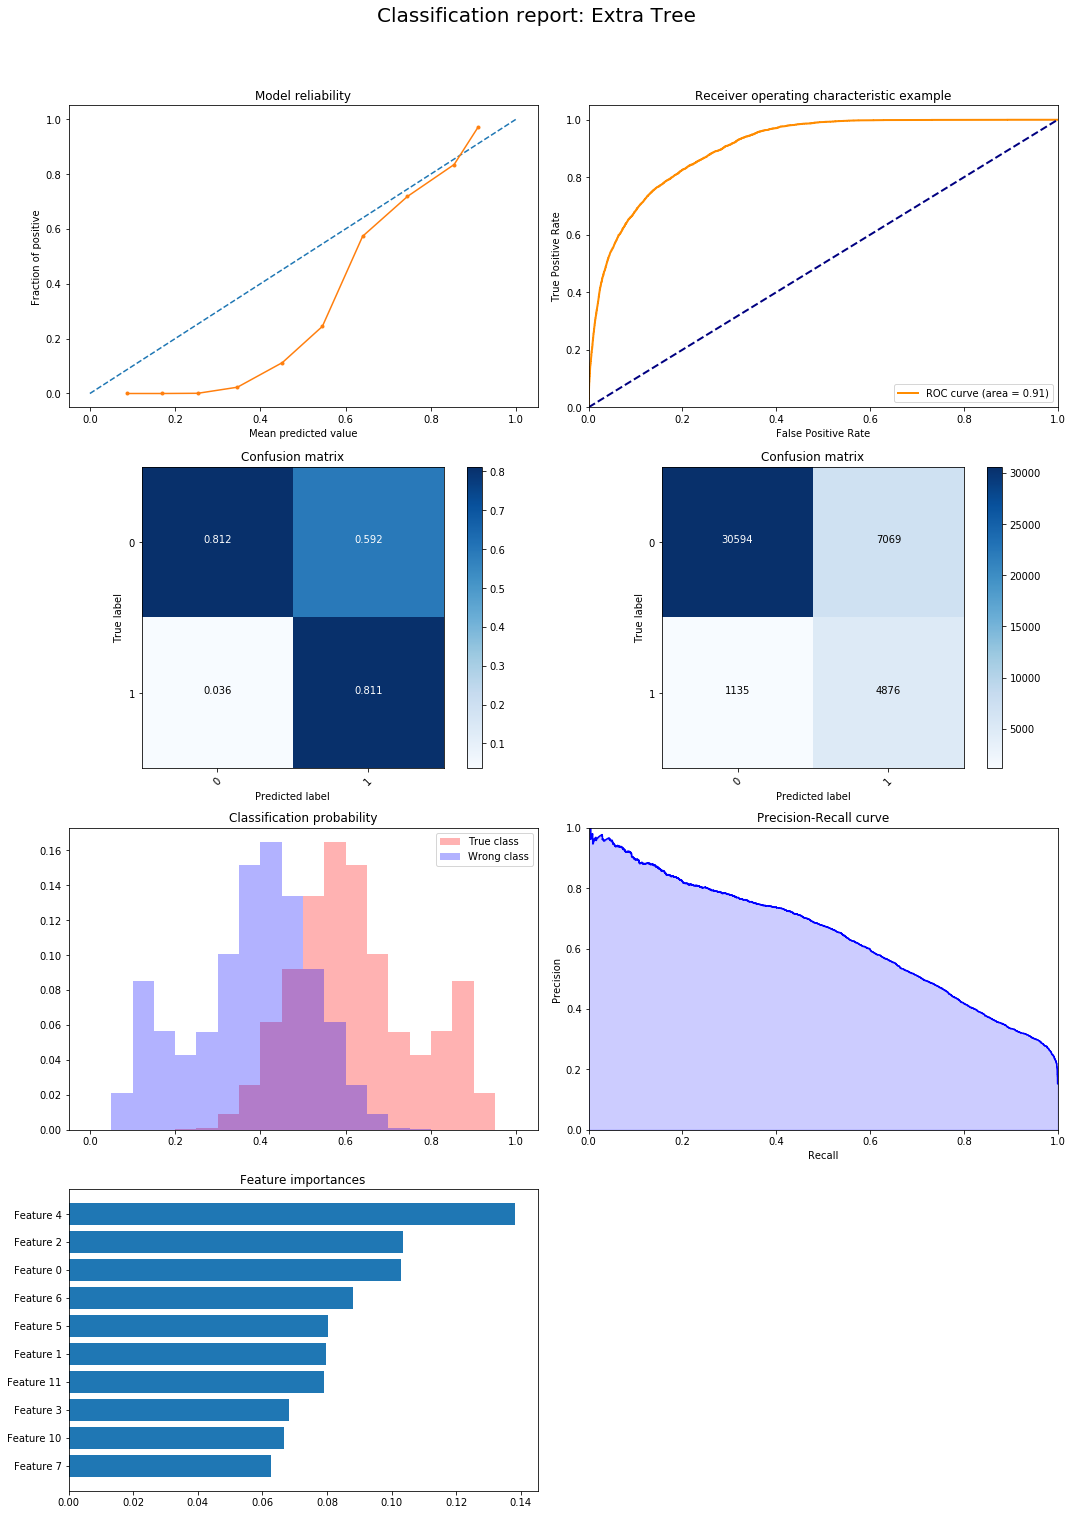

In [41]:
plot_report('Extra Tree', model, X_test, y_test)

* Performance ExtraTrees improves w.r.t. the simple logistic regression: F1 = 0.46;
* The classification probability plot still shows poor class separation;
* Performance are limited by a large amount of False Positive which amount to about 60% of the total Positive prediction;
* The model gives more weights to NUM_MONTHS_SOFFERENZA (Feature 4), MAX_IMP_GBV and IMP_GBV (Feature 2 and =0);

## Extra Random Tree w/ PCA

In [42]:
%%time

from sklearn.ensemble import ExtraTreesClassifier

model=train_model('ETC'
            , model = ExtraTreesClassifier(n_estimators=250, min_samples_split=10, min_samples_leaf=10, n_jobs=-1, random_state=0, class_weight='balanced_subsample')
            , X=X_train, y=y_train
            , categorical_features=[]
            , pca_n_components=4
            , save=False)

CPU times: user 34.3 s, sys: 670 ms, total: 35 s
Wall time: 10.1 s


In [43]:
# Performance on 1 split
from sklearn.metrics import classification_report
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.97      0.85      0.91     37663
        True       0.47      0.85      0.61      6011

    accuracy                           0.85     43674
   macro avg       0.72      0.85      0.76     43674
weighted avg       0.90      0.85      0.87     43674



In [44]:
# Cross validation
cross_validate_model(model, X_train, y_train, cv=3)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   26.1s finished


,F1,Precision,Recall,Roc auc
error,0.005309,0.005354,0.004639,0.003499
value,0.533960,0.402377,0.793491,0.884688


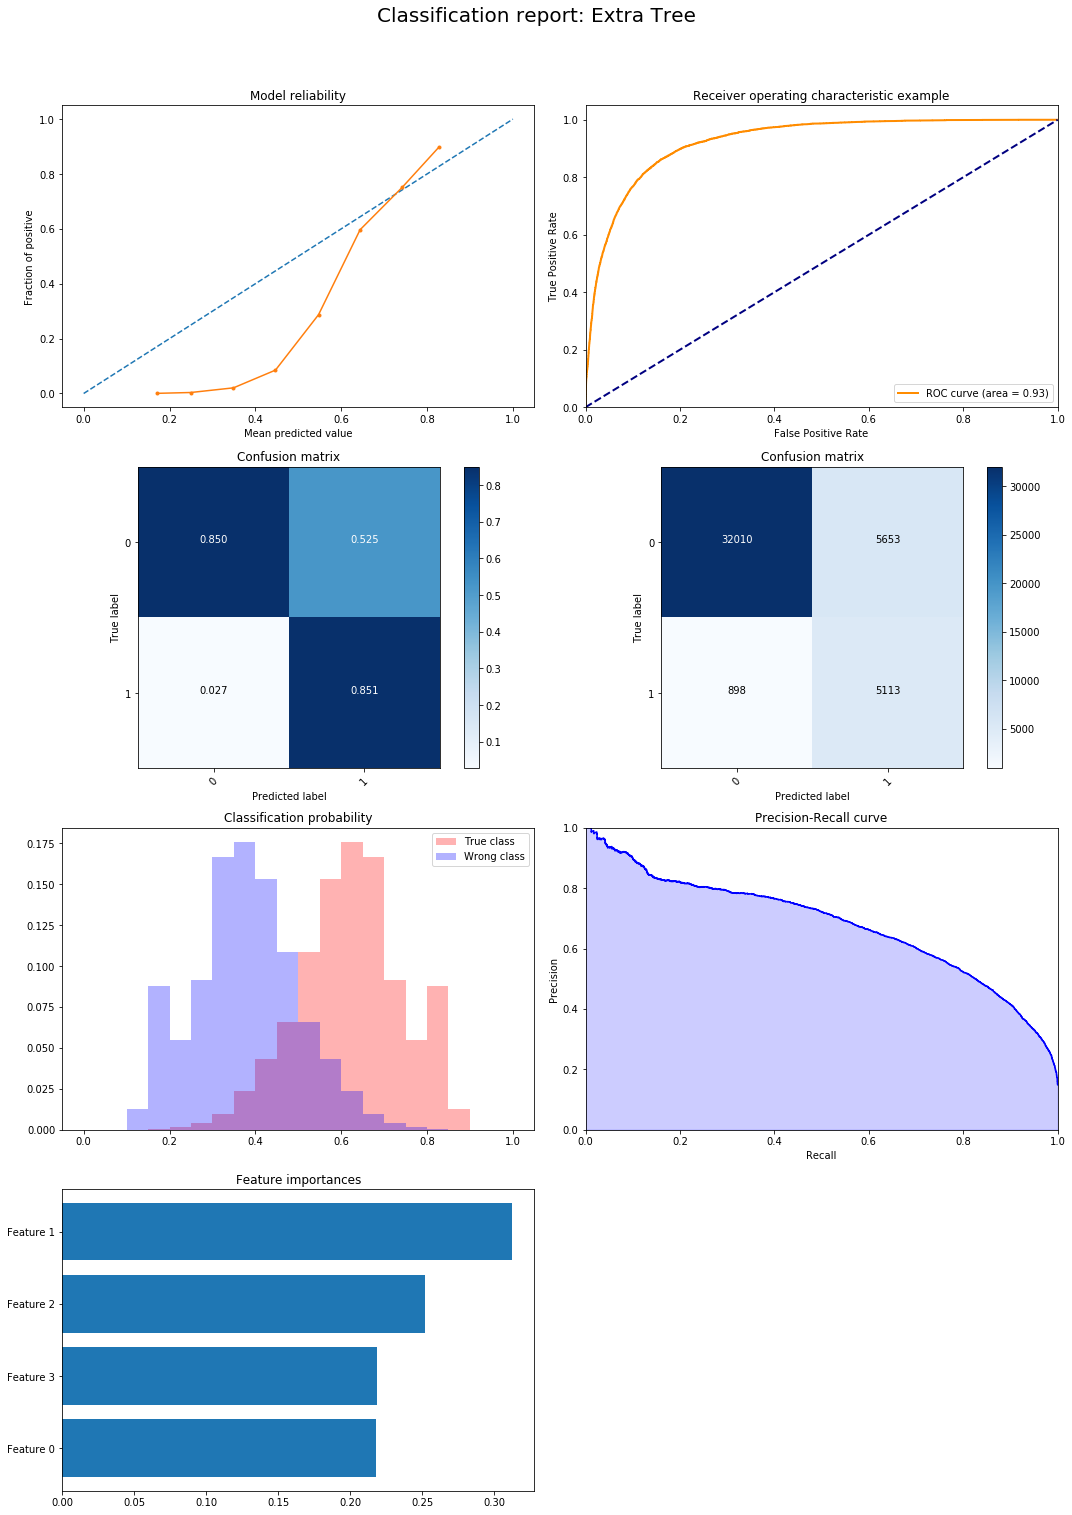

In [45]:
plot_report('Extra Tree', model, X_test, y_test)

* PCA seems to help ExtraTrees performance: F1 = 0.53;
* The clasisfication probability plot shows an improving class separation;
* Performance are still limited by a large amount of False Positive which amount to about 52% of the total Positive prediction;

## Random Forest w/o PCA

In [46]:
%%time

from sklearn.ensemble import RandomForestClassifier

model=train_model('RF'
            , model = RandomForestClassifier(n_estimators=500, min_samples_split=2, min_samples_leaf=2, n_jobs=-1, random_state=0, class_weight='balanced_subsample')
            , X=X_train, y=y_train
            , categorical_features=[]
            , pca_n_components=0
            , save=False)

CPU times: user 3min 30s, sys: 2.88 s, total: 3min 33s
Wall time: 1min 3s


In [47]:
# Performance on 1 split
from sklearn.metrics import classification_report
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.98      0.99      0.99     37663
        True       0.93      0.89      0.91      6011

    accuracy                           0.98     43674
   macro avg       0.95      0.94      0.95     43674
weighted avg       0.97      0.98      0.97     43674



In [48]:
# Cross validation
cross_validate_model(model, X_train, y_train, cv=3)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.5min finished


,F1,Precision,Recall,Roc auc
error,0.003307,0.007509,0.001147,0.000850
value,0.850059,0.891988,0.811925,0.981209


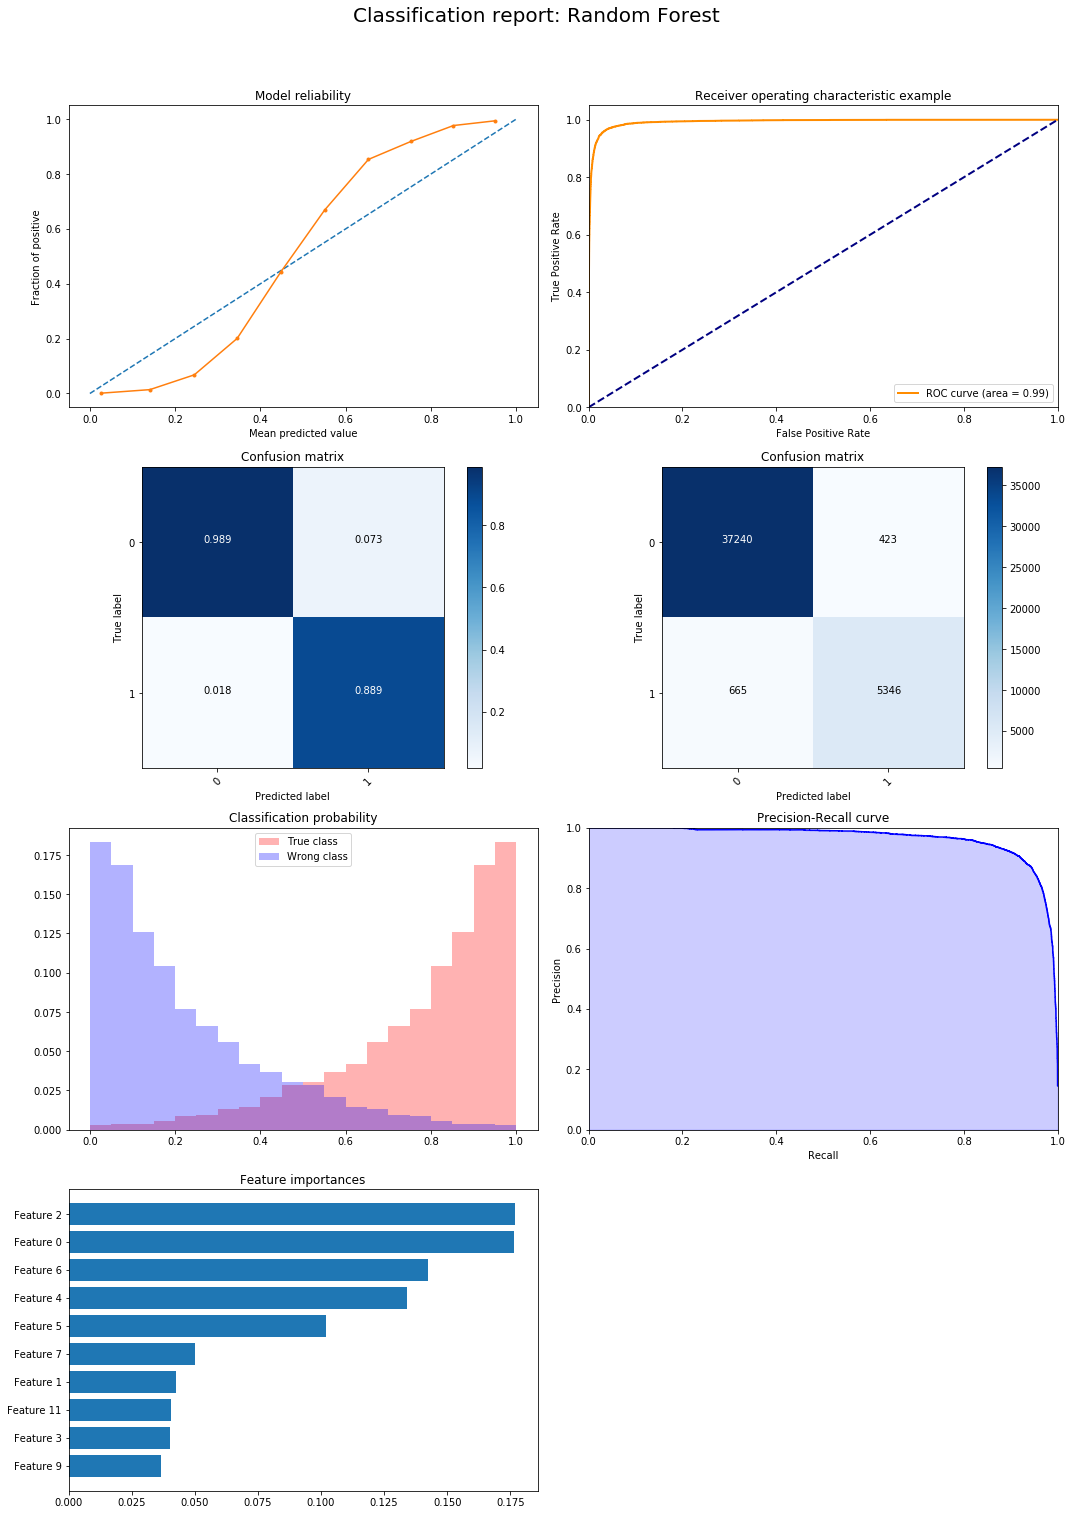

In [49]:
plot_report('Random Forest', model, X_test, y_test)

* The random forest is finally a model with good performance: F1=0.85
* The classification probability shows the two classes are well sepated;
* The confusion matrix looks good, whith strong diagonal elements and low classification errors;
* Model reliability also appear good, suggesting that output fo the classifier can be directly adoped as probability estimation;
* In summary, all performance metrics and model quality plots seem satisfying!

## Random Forest w/ PCA

In [50]:
%%time

from sklearn.ensemble import RandomForestClassifier

model=train_model('RF'
            , model = RandomForestClassifier(n_estimators=250, min_samples_split=2, min_samples_leaf=2, n_jobs=-1, random_state=0, class_weight='balanced_subsample')
            , X=X_train, y=y_train
            , categorical_features=[]
            , pca_n_components=4
            , save=False)

CPU times: user 3min 9s, sys: 1.62 s, total: 3min 11s
Wall time: 1min


In [51]:
# Performance on 1 split
from sklearn.metrics import classification_report
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.96      0.98      0.97     37663
        True       0.89      0.75      0.81      6011

    accuracy                           0.95     43674
   macro avg       0.92      0.87      0.89     43674
weighted avg       0.95      0.95      0.95     43674



In [52]:
# Cross validation
cross_validate_model(model, X_train, y_train, cv=3)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.9min finished


,F1,Precision,Recall,Roc auc
error,0.005909,0.005814,0.005912,0.002277
value,0.738315,0.837783,0.659962,0.948915


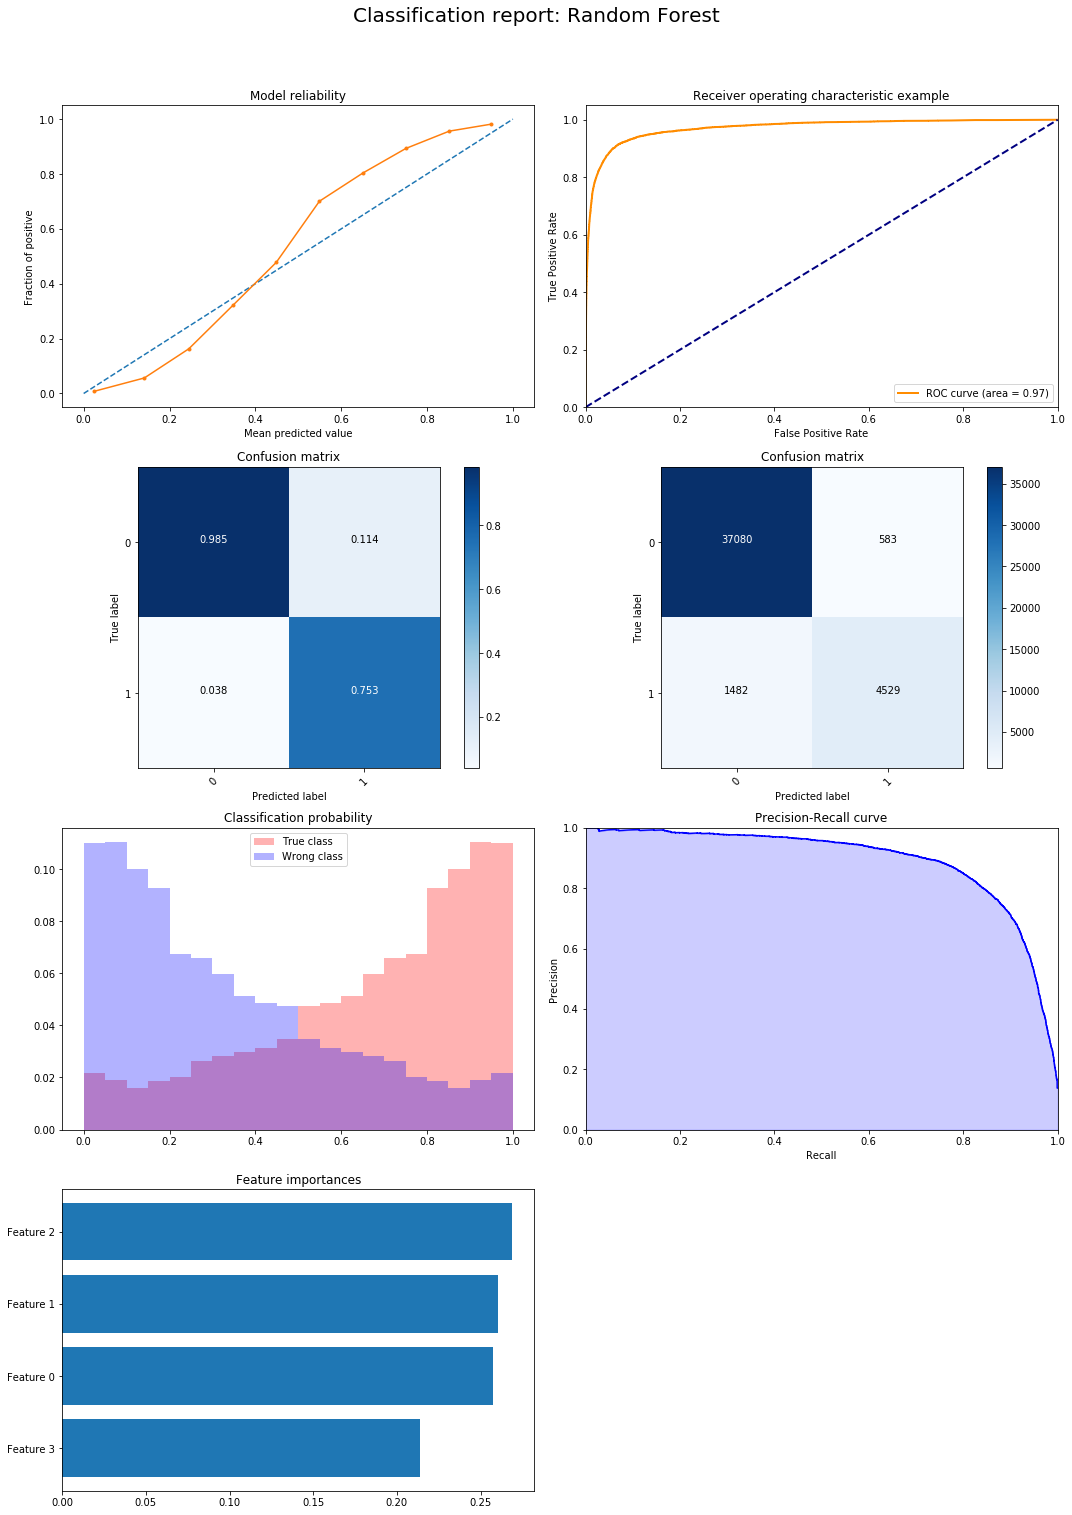

In [53]:
plot_report('Random Forest', model, X_test, y_test)

* The PCA does not help this model: F1=0.74
* Overall results are good, but the same model without PCA looks better;

## Parameter optimization with GridSearch:

Considering the best performing model, I perform a random grid search to optimize model's hyperparameters. The step run for about 4-5 hours on my laptop, best performance are obtained for:

* max_depth=None,
* max_features=n_features, 
* min_samples_leaf=2, 
* min_samples_split=2,
* n_estimators=500,
     
Best model performancs is: F1 = 0.86, which is compatible with the values obtained without GridSearch.
    
This excercise show the model's hypermarameters used during the first iteration are good.

In [54]:
%%time

param_grid = [{
    'model__n_estimators' : [50,250,500],
    'model__min_samples_split' : [2,10,100],
    'model__min_samples_leaf' : [2,10,100],
    'model__max_depth' : [3,5,None],
    'model__max_features' : [16,'sqrt',None],
}]

steps = [
    ('scaler', StandardScaler()),
    ('model', RandomForestClassifier(n_jobs=-1, random_state=0, class_weight='balanced_subsample'))
]

model = Pipeline(steps)

from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='f1', verbose=10, n_jobs=-1)

# Comment out since it require 4-5 hours on my laptop
#grid_search.fit(X_train, y_train)

CPU times: user 1.91 ms, sys: 47.3 ms, total: 49.3 ms
Wall time: 49.6 ms


In [55]:
#cvres=grid_search.cv_results_
#max(cvres['mean_test_score'])

In [56]:
#best_model = grid_search.best_estimator_

In [57]:
#best_model

# Regression

For the regression task, I use the selected features to train a regression model to predict the target variable 'RECOVERY_RATE_12M_AHEAD'.

I test two types of model:
1. **Linear regression**
2. **Random Forest regression**

All models are tested with and without PCA for dimensionality reduction using 4 components, as highlighet in the analysis performed right above.

### Model performance:

For each model, the performance are evaluated using different metrics: 
* **R^2**: represents the proportion of variance (of y) that has been  explained by the independent variables in the model. It provides an indication of goodness of fit and therefore a measure of how well unseen samples are likely to be predicted by the model, through the proportion of explained variance;
* **MSE**: measures the average of the squares of the errors;

The metrics are calculated on the test sample as well as on the train sample using a 3-fold cross-validation approach to test for model overfitting. The model with the highest performance will be retrained.

### Model quality:

Aside from the numerical metrics, some additional handle on the model performance is given by the plot provided for each model tested:

* **Residual distribution**: distribution of the residual, i.e. True Value - Predicted Values for each sample;
* **Feature importance**: the importance given by the model to the features used during the model training (features are enumerated by their position in the feature vector).

In [58]:
y_train = y_train_regressor
y_test = y_test_regressor

## Linear Regression w/o PCA

In [59]:
%%time
from sklearn.linear_model import LinearRegression

model=train_model('linear_regression_wo_pca'
            , model = LinearRegression()
            , X=X_train, y=y_train
            , categorical_features = []
            , pca_n_components=0
            , save=False)

CPU times: user 113 ms, sys: 30.8 ms, total: 143 ms
Wall time: 129 ms


/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


In [60]:
print('R2 on test sample: %.3f' % model.score(X_test, y_test))
y_pred = model.predict(X_test)
print('MSE on test sample: %.3f' % mean_squared_error(y_test, y_pred))

R2 on test sample: 0.011
MSE on test sample: 0.015


In [61]:
cross_validate_model(model, X_train,y_train, 
                     scoring=['r2', 'neg_mean_squared_error'])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    1.3s finished


,Neg mean squared error,R2
error,0.000645,0.001737
value,-0.014481,0.008452


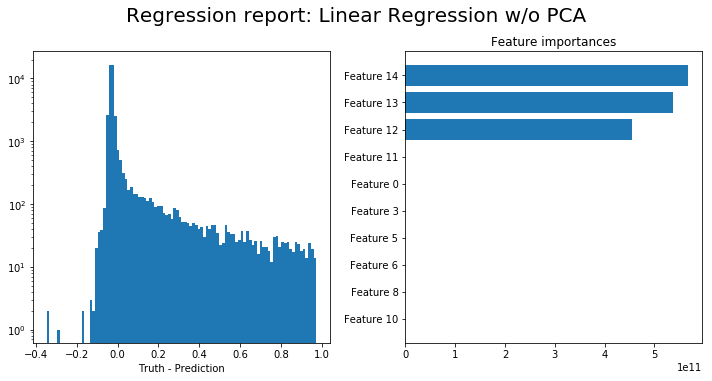

In [62]:
reg_plot_report('Linear Regression w/o PCA', model, X_test,y_test)

* Performance are rather poor: R2 = 0.008;
* Residual distribution shows that Prediction is sistematically lower than Truth value (residual > 0);
* It is also suspicius that the only features relevant for the model are the One Hot Encoded values of 'COD_TIPO_NDG';

## Linear Regressio w/ PCA

In [63]:
%%time
from sklearn.linear_model import LinearRegression

model=train_model('linear_regression_w_pca'
            , model = LinearRegression()
            , X=X_train, y=y_train
            , categorical_features=[]
            , pca_n_components=4
            , save=False)

CPU times: user 457 ms, sys: 126 ms, total: 584 ms
Wall time: 429 ms


In [64]:
print('R2 on test sample: %.3f' % model.score(X_test, y_test))
y_pred = model.predict(X_test)
print('MSE on test sample: %.3f' % mean_squared_error(y_test, y_pred))

R2 on test sample: 0.008
MSE on test sample: 0.015


In [65]:
cross_validate_model(model, X_train,y_train, cv=3,
                     scoring=['r2', 'neg_mean_squared_error'])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.8s finished


,Neg mean squared error,R2
error,0.000086,0.000409
value,-0.014502,0.007072


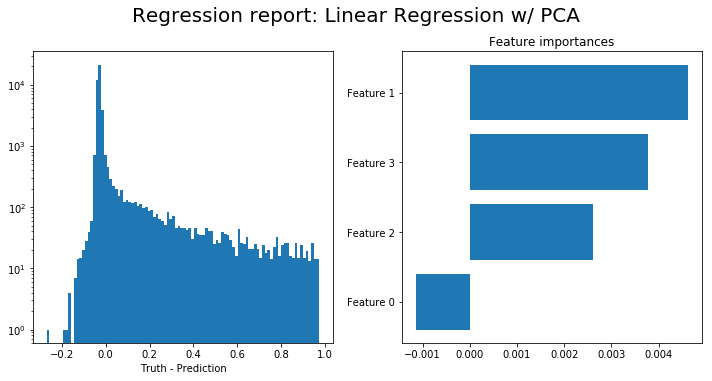

In [66]:
reg_plot_report('Linear Regression w/ PCA', model, X_test,y_test)

* Performance does not improve using PCA: R2 = 0.007;
* Residual distribution shows that Prediction is sistematically lower than Truth value (residual > 0);
* A simple Linear Regression model does not seems to work wel in this case;

## RandomForest w/o PCA

In [67]:
%%time
from sklearn.ensemble import RandomForestRegressor

model=RandomForestRegressor(n_estimators=500, min_samples_split=2, min_samples_leaf=2, n_jobs=-1, random_state=0,)

model=train_model('random_forest_wo_pca'
            , model = model
            , X=X_train, y=y_train
            , categorical_features=[]
            , pca_n_components=0
            , save=False)

CPU times: user 12min 1s, sys: 3.17 s, total: 12min 4s
Wall time: 3min 22s


In [68]:
print('R2 on test sample: %.3f' % model.score(X_test, y_test))
y_pred = model.predict(X_test)
print('MSE on test sample: %.3f' % mean_squared_error(y_test, y_pred))

R2 on test sample: 0.777
MSE on test sample: 0.003


In [69]:
cross_validate_model(model, X_train,y_train, cv=3,
                     scoring=['r2', 'neg_mean_squared_error'])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  8.2min finished


,Neg mean squared error,R2
error,0.000065,0.002660
value,-0.004956,0.660667


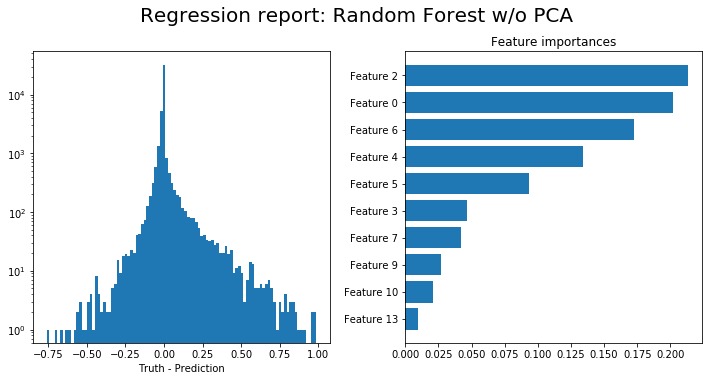

In [70]:
reg_plot_report('Random Forest w/o PCA', model, X_test,y_test)

* Performance using Random Forest Classifier seems quite good: R2 = 0.66;
* Residual distribution is symmetric around zero;
* The model seems to be driven by 'MAX_IMP_GBV' (Feature 2), 'IMP_GBV' (Feature 0) and 'Credito Vantato' (Feature 6)
* I do not optimize paramter with GridSearch as done for the classifier. I expect the hyperparameters to be already quite good. Performance should not change much with fine tuning.

## RandomForest w/ PCA

In [71]:
%%time
from sklearn.ensemble import RandomForestRegressor

model=RandomForestRegressor(n_estimators=500, min_samples_split=2, min_samples_leaf=2, n_jobs=-1, random_state=0,)

model=train_model('random_forest_w_pca'
            , model = model
            , X=X_train, y=y_train
            , categorical_features=[]
            , pca_n_components=4
            , save=False)

CPU times: user 12min 7s, sys: 4.22 s, total: 12min 11s
Wall time: 9min 46s


In [72]:
print('R2 on test sample: %.3f' % model.score(X_test, y_test))
y_pred = model.predict(X_test)
print('MSE on test sample: %.3f' % mean_squared_error(y_test, y_pred))

R2 on test sample: 0.580
MSE on test sample: 0.007


In [73]:
cross_validate_model(model, X_train,y_train, cv=3,
                     scoring=['r2', 'neg_mean_squared_error'])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed: 11.1min finished


,Neg mean squared error,R2
error,0.000095,0.007248
value,-0.007839,0.463303


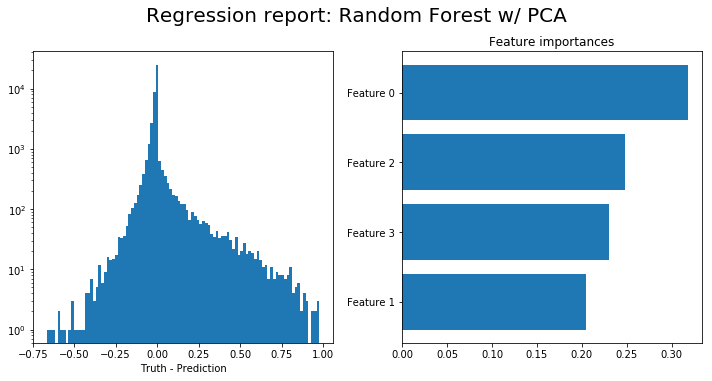

In [74]:
reg_plot_report('Random Forest w/ PCA', model, X_test,y_test)

* Performance using Random Forest Classifier with PCA worsen: R2 = 0.49;
* Residual distribution is symmetric around zero;
* The model seems to be driven by PCA Feature 0, 2 and 3;

## Summary
Let's summarize the performance for the models considered:

(The values within parenthesis represent the performance measured on the test sample)

### Classification:
Model                      | F1          | Precision   | Recall      | ROC AUC |
---------------------------|-------------|-------------|-------------|---------|
Logistic Regression        | 0.33 (0.35) | 0.23 (0.23) | 0.65 (0.66) | 0.69      |
Logistic Regression w/ PCA | 0.30 (0.31) | 0.21 (0.21) | 0.58 (0.59) | 0.65      |
Extra Random Trees         | 0.46 (0.54) | 0.34 (0.41) | 0.74 (0.81) | 0.86      |
Extra Random Trees w/ PCA  | 0.53 (0.61) | 0.40 (0.47) | 0.79 (0.85) | 0.88      |
** Random Forest**         | **0.85 (0.91)** | **0.89 (0.93)** | **0.81 (0.89)** | **0.98** |
Random Forest w/ PCA       | 0.74 (0.81) | 0.84 (0.89) | 0.66 (0.75) | 0.95      |

The best performance for the classificaiton task is obtained with a Random Forest Classifier without PCA.

### Regression
Model                           | R2             | MSE         | 
--------------------------------|----------------|-------------|
Linear Regression               | 0.008 (0.0011) | 0.014 (0.015) | 
Linear Regression w/ PCA        | 0.0007 (0.008) | 0.014 (0.015) | 
** Random Forest Regression**   | **0.661 (0.777)** | **0.005 (0.003)** |
Random Forest Regression w/ PCA | 0.490 (0.580)  | 0.007 (0.007) | 

The best performance for the regression task is obtained with a Random Forest Regressor without PCA.

### Next steps
This is a fist version of the models to fulfill the challenge's objective. The models relies on 12 numerical features and 1 categorical feature chosen because of their correlation with the target variables. Models' performances are quite good and will provide reliable ranking of NPLs.

Within an agile working methodology, this could be considered as a first model release to put in production right away. The team could keep working in the background toward future improved releases, based on additional finding, feedbacks from users and stakeholders.

Many possible paths could be explored to test improvement of the models' performances:
* Include categorical features which have been excluded far;
* Test extensively with different combination of features;
* Train different models for different customer categories (see modeling_and_performance_part2.ipynb);
* Train different models for different geographical areas;

